<a href="https://colab.research.google.com/github/JosephThompson607/malb_graph/blob/main/classifying_SALB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # prompt: deletes all .pt files in /content/drive/MyDrive/ALB_stuff/pytorch_datasets/


# def delete_pt_files(directory):
#   """Deletes all .pt files in the specified directory.
#   """
#   for filename in glob.glob(os.path.join(directory, "*.pt")):
#     try:
#       os.remove(filename)
#       print(f"Deleted: {filename}")
#     except OSError as e:
#       print(f"Error deleting {filename}: {e}")

# # Example usage:
# directory_to_clean = "/content/drive/MyDrive/ALB_stuff/pytorch_datasets/processed"
# delete_pt_files(directory_to_clean)

In [65]:
! pip install torch_geometric

In [66]:
# prompt: #adds /content/drive/MyDrive/ALB_stuff/python/ALB_instance_tools.py

# Add the specified file to the current path, assuming it exists.
import sys
import os.path as osp
import os
import glob

sys.path.append('/content/drive/MyDrive/ALB_stuff/python/')
from ALB_instance_tools import *
from ALB_station_fill_heuristic import *
from classification_generation import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import graphviz
try:
    import pygraphviz
except ImportError:
    !pip install pygraphviz



# Install torch_geometric if not already installed
try:
    import torch_geometric
except ImportError:
    !pip install torch-geometric

from torch_geometric.data import Dataset, Data, InMemoryDataset


  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)


In [67]:
instance_list = get_instance_list("/content/drive/MyDrive/ALB_stuff/pytorch_datasets/raw/small data set_n=20")
comp_df = generate_heuristic_comparison(instance_list)

             instance_name  positional_weight  reverse_positional_weight  \
0    instance_n=20_500.alb                  7                          7   
1    instance_n=20_107.alb                 13                         13   
2    instance_n=20_421.alb                  5                          5   
3     instance_n=20_45.alb                  5                          5   
4    instance_n=20_193.alb                  4                          4   
..                     ...                ...                        ...   
520  instance_n=20_517.alb                  3                          2   
521  instance_n=20_524.alb                  2                          2   
522  instance_n=20_525.alb                  2                          2   
523  instance_n=20_519.alb                  2                          2   
524  instance_n=20_516.alb                  2                          2   

     n_followers  n_predecessors  n_immediate_followers  work_element_time  \
0        

In [68]:
test_alb = SALBP_Instance(instance_list[0], instance_list[0])
tasks = test_alb.task_times.copy()
#orders tasks by task number (turns string to int), returns task times (value of dict)
tasks = dict(sorted(tasks.items(), key=lambda item: int(item[0])))
print
task_times = list(tasks.values())
task_times


[238,
 508,
 501,
 511,
 469,
 53,
 256,
 445,
 132,
 100,
 271,
 445,
 52,
 162,
 555,
 195,
 563,
 60,
 235,
 485]

In [69]:


class SALBDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None,raw_data_folder = "raw/small data set_n=20", alb_filepath=None):
        self.raw_data_folder = raw_data_folder
        self.alb_files = get_instance_list(alb_filepath, keep_directory_location=False)
        self.instance_length = len(self.alb_files)
        super().__init__(root, transform, pre_transform)

    @property
    def raw_dir(self):
        # Define your custom raw directory
        return osp.join(self.root, self.raw_data_folder)
    @property
    def processed_dir(self):
        # Define your custom processed directory
        return osp.join(self.root, 'processed/')

    @property
    def raw_file_names(self):
        # List files in `raw_dir` necessary for generating the dataset.
        return self.alb_files

    @property
    def processed_file_names(self):
        # List files in `processed_dir` that are already processed.
        return [f"instance_n=20_{idx}.pt" for idx in range(1,self.instance_length+1)]

    def download(self):
        # Logic for downloading raw data if it does not exist.
        pass

    def process(self):
        # Read raw data and save processed data to `processed_dir`.
        for raw_path in self.raw_paths:
            print(f"Processing {raw_path}...")
            name = raw_path.split("/")[-1].split(".")[0].split("_")[-1]
            # Example: Read graph data
            salb_inst = SALBP_Instance("test",raw_path)
            edge_index = torch.tensor(salb_inst.get_python_edge_list(), dtype=torch.long)
            x = torch.tensor([salb_inst.get_task_times_list()], dtype=torch.float)
            #y = torch.tensor([0], dtype=torch.long)

            data = Data(x=x, edge_index=edge_index.t().contiguous())
            torch.save(data, self.processed_dir +"instance_n=20_" + name + ".pt")

    def len(self):
        # Return the number of graphs in the dataset.
        return len(self.processed_file_names)

    def get(self, idx):
        # Load and return a graph object by index. NOTE: INDEXING STARTS AT 1 to stay consistent with Otto
        data = torch.load(f"{self.processed_dir}/instance_n=20_{idx}.pt")
        return data


my_dataset = SALBDataset(root='/content/drive/MyDrive/ALB_stuff/pytorch_datasets', alb_filepath="/content/drive/MyDrive/ALB_stuff/pytorch_datasets/raw/small data set_n=20")

In [70]:
my_dataset

SALBDataset(525)

<ipython-input-69-e8d4eeb77be3>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f"{self.processed_dir}/instance_n=20_{idx}.pt")


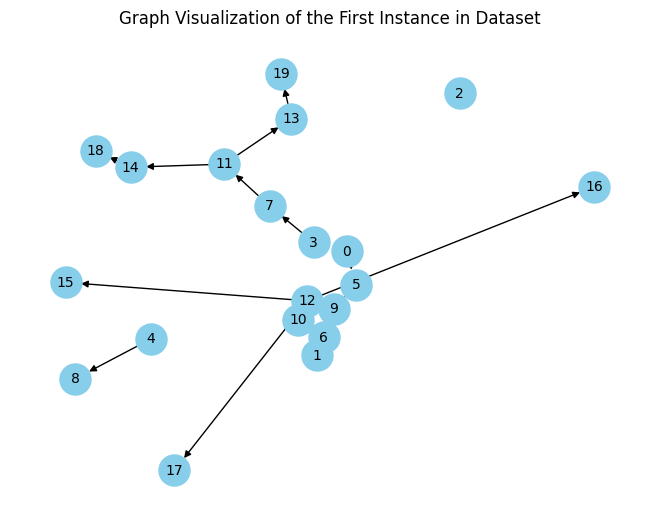

In [76]:
# prompt: Graphs the first graph of my_dataset

import matplotlib.pyplot as plt
import networkx as nx

# Assuming the first graph in my_dataset is at index 0
data = my_dataset[1]

# Create a NetworkX graph from the PyTorch Geometric Data object
graph = nx.DiGraph()
edge_index = data.edge_index.numpy()
#adds nodes
for j in range(data.x.shape[1]):
    graph.add_node(j)
#adds edges
for i in range(edge_index.shape[1]):
    graph.add_edge(edge_index[0, i], edge_index[1, i])


# Draw the graph, changes graph to graphviz and uses
nx.draw(graph, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black")
plt.title("Graph Visualization of the First Instance in Dataset")
plt.show()